In [1]:
from data_loader import load_and_prepare_data
from credit_models import modelValuation
from pytorch_tabnet.tab_model import TabNetClassifier
from tuner import tune_model

c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
(X_train, X_test, Y_train, Y_test), cat_idxs, cat_dims = load_and_prepare_data('tabnet')

# Get best hyperparameters from tuning
best_params = tune_model("tabnet", X_train, Y_train, n_trials=10, n_splits=2 , cat_idxs= cat_idxs , cat_dims= cat_dims)

# Prepare required fields from best_params
tabnet_params = {
    "n_d":              best_params["n_d"],
    "n_a":              best_params["n_a"],
    "n_steps":          best_params["n_steps"],
    "gamma":            best_params["gamma"],
    "lambda_sparse":    best_params["lambda_sparse"],
    "optimizer_params": {"lr": best_params["lr"]},
    "mask_type":        best_params["mask_type"],
    "cat_emb_dim":      best_params["cat_emb_dim"],
    "verbose":          0,
    "device_name":      "auto",
    "cat_idxs":         cat_idxs,
    "cat_dims":         cat_dims,
}


# Train final model
model = TabNetClassifier(**tabnet_params)
model.fit(
    X_train=X_train, y_train=Y_train,
    eval_set=[(X_test, Y_test)],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    weights=1
)

# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]


[I 2025-06-10 17:13:50,115] A new study created in memory with name: no-name-3f78c919-1fed-4a53-a103-13c29b2b0858


Stop training because you reached max_epochs = 100 with best_epoch = 91 and best_val_0_auc = 0.64019


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:14:49,778] Trial 0 finished with value: 0.6104604362593918 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_a': 8, 'n_steps': 3, 'gamma': 1.038346236018818, 'lambda_sparse': 1.0746231734799921e-06, 'lr': 0.02966921676600012, 'cat_emb_dim': 3}. Best is trial 0 with value: 0.6104604362593918.


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_auc = 0.6489

Early stopping occurred at epoch 17 with best_epoch = 2 and best_val_0_auc = 0.54096


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:15:24,609] Trial 1 finished with value: 0.5455943581447059 and parameters: {'mask_type': 'sparsemax', 'n_d': 28, 'n_a': 24, 'n_steps': 5, 'gamma': 1.149640787083675, 'lambda_sparse': 1.471462415844445e-06, 'lr': 0.01244319814681907, 'cat_emb_dim': 1}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 80 with best_epoch = 65 and best_val_0_auc = 0.59189

Early stopping occurred at epoch 17 with best_epoch = 2 and best_val_0_auc = 0.57333


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:15:39,121] Trial 2 finished with value: 0.47251664572681057 and parameters: {'mask_type': 'entmax', 'n_d': 8, 'n_a': 20, 'n_steps': 4, 'gamma': 1.7780172883893264, 'lambda_sparse': 0.0005816065536845048, 'lr': 0.02854995719716214, 'cat_emb_dim': 3}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 37 with best_epoch = 22 and best_val_0_auc = 0.59316

Early stopping occurred at epoch 16 with best_epoch = 1 and best_val_0_auc = 0.56755


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:16:01,604] Trial 3 finished with value: 0.5339854145600863 and parameters: {'mask_type': 'sparsemax', 'n_d': 8, 'n_a': 24, 'n_steps': 3, 'gamma': 1.0420552014858797, 'lambda_sparse': 5.063705707048679e-05, 'lr': 0.02502801672462316, 'cat_emb_dim': 2}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 89 with best_epoch = 74 and best_val_0_auc = 0.62718

Early stopping occurred at epoch 33 with best_epoch = 18 and best_val_0_auc = 0.56974


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:16:46,460] Trial 4 finished with value: 0.5474588602379599 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_a': 24, 'n_steps': 7, 'gamma': 1.2205799502517152, 'lambda_sparse': 0.000519549029678393, 'lr': 0.01440096947988928, 'cat_emb_dim': 1}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 35 with best_epoch = 20 and best_val_0_auc = 0.54578

Early stopping occurred at epoch 18 with best_epoch = 3 and best_val_0_auc = 0.57037


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:17:06,421] Trial 5 finished with value: 0.4857721368036557 and parameters: {'mask_type': 'entmax', 'n_d': 12, 'n_a': 16, 'n_steps': 7, 'gamma': 1.59348798833906, 'lambda_sparse': 2.526891876765491e-05, 'lr': 0.027174828134334805, 'cat_emb_dim': 3}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 30 with best_epoch = 15 and best_val_0_auc = 0.55391

Early stopping occurred at epoch 18 with best_epoch = 3 and best_val_0_auc = 0.57246


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:17:17,754] Trial 6 finished with value: 0.5376792524002252 and parameters: {'mask_type': 'sparsemax', 'n_d': 16, 'n_a': 12, 'n_steps': 4, 'gamma': 1.7775802433017296, 'lambda_sparse': 0.00017740465244636745, 'lr': 0.014929496361552132, 'cat_emb_dim': 3}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 25 with best_epoch = 10 and best_val_0_auc = 0.57348

Early stopping occurred at epoch 71 with best_epoch = 56 and best_val_0_auc = 0.59798


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:18:06,886] Trial 7 finished with value: 0.5762838530615821 and parameters: {'mask_type': 'entmax', 'n_d': 32, 'n_a': 20, 'n_steps': 6, 'gamma': 1.4756103160210787, 'lambda_sparse': 4.6097134875017976e-05, 'lr': 0.01907984383989193, 'cat_emb_dim': 2}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 51 with best_epoch = 36 and best_val_0_auc = 0.59821

Early stopping occurred at epoch 32 with best_epoch = 17 and best_val_0_auc = 0.57626


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:18:31,914] Trial 8 finished with value: 0.5749620270180705 and parameters: {'mask_type': 'entmax', 'n_d': 12, 'n_a': 16, 'n_steps': 5, 'gamma': 1.9159214598931178, 'lambda_sparse': 1.4662714502074493e-05, 'lr': 0.022256299396598005, 'cat_emb_dim': 1}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 54 with best_epoch = 39 and best_val_0_auc = 0.60467

Early stopping occurred at epoch 23 with best_epoch = 8 and best_val_0_auc = 0.55833


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-06-10 17:19:02,267] Trial 9 finished with value: 0.5563791242530918 and parameters: {'mask_type': 'sparsemax', 'n_d': 20, 'n_a': 28, 'n_steps': 6, 'gamma': 1.4327335346170238, 'lambda_sparse': 7.543598183845136e-06, 'lr': 0.024179616271640607, 'cat_emb_dim': 1}. Best is trial 0 with value: 0.6104604362593918.



Early stopping occurred at epoch 57 with best_epoch = 42 and best_val_0_auc = 0.62214

Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_auc = 0.72139


c:\Users\KrishnaWali\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



[⚙️ TabNet] Using Best Threshold = 0.2312 (F1 = 0.705, P = 0.663, R = 0.754)

🔍 [TabNet] Classification Report @ Threshold = 0.23120099306106567
                 precision    recall  f1-score   support

Good Credit (0)       0.71      0.62      0.66       500
 Bad Credit (1)       0.66      0.75      0.71       500

       accuracy                           0.69      1000
      macro avg       0.69      0.69      0.68      1000
   weighted avg       0.69      0.69      0.68      1000

🧠 Explanation of Key Metrics:
- Precision (Good Credit): 0.71 → 71% of those predicted as good credit were correct.
- Recall (Good Credit)   : 0.62 → 62% of all actual good credits were correctly identified.
- Precision (Bad Credit) : 0.66 → 66% of those predicted as bad credit were correct.
- Recall (Bad Credit)    : 0.75 → 75% of all actual bad credits were correctly identified.
- Accuracy               : 0.69 → 68% of all predictions were correct.
- ROC-AUC                : 0.72 → Model distinguishes 

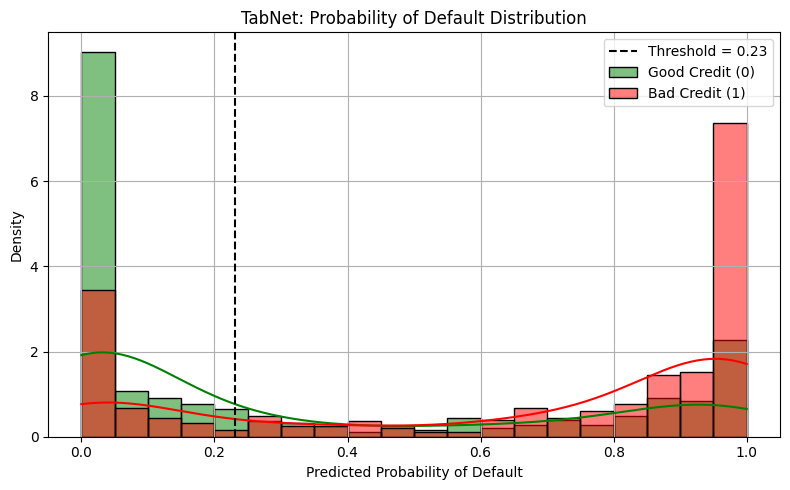

In [6]:
y_pred, chosen_thresh = modelValuation("TabNet", Y_test, y_proba, use_best_threshold=True)


[⚙️ TabNet] Using Default Threshold = 0.5

🔍 [TabNet] Classification Report @ Threshold = 0.5
                 precision    recall  f1-score   support

Good Credit (0)       0.68      0.69      0.68       500
 Bad Credit (1)       0.68      0.67      0.68       500

       accuracy                           0.68      1000
      macro avg       0.68      0.68      0.68      1000
   weighted avg       0.68      0.68      0.68      1000

🧠 Explanation of Key Metrics:
- Precision (Good Credit): 0.68 → 68% of those predicted as good credit were correct.
- Recall (Good Credit)   : 0.69 → 69% of all actual good credits were correctly identified.
- Precision (Bad Credit) : 0.68 → 68% of those predicted as bad credit were correct.
- Recall (Bad Credit)    : 0.67 → 67% of all actual bad credits were correctly identified.
- Accuracy               : 0.68 → 68% of all predictions were correct.
- ROC-AUC                : 0.72 → Model distinguishes good vs. bad credit with 72% confidence.


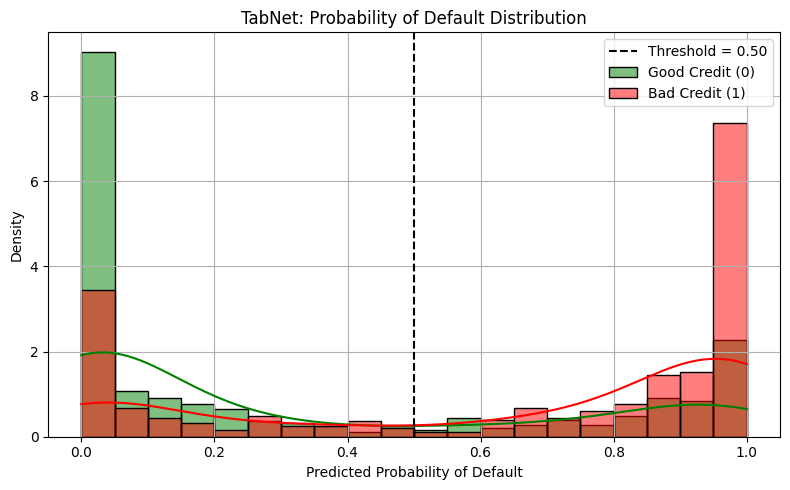

In [7]:
y_pred, chosen_thresh = modelValuation("TabNet", Y_test, y_proba, use_best_threshold=False)

In [9]:
import joblib
joblib.dump(y_proba, "proba_tab.pkl") 
model.save_model("tabnet_model.zip")


Successfully saved model at tabnet_model.zip.zip


'tabnet_model.zip.zip'